In [1]:
import random
import torch
from torch import nn
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torchvision
import matplotlib
import matplotlib.pyplot as plt

Sample Data Upload

In [2]:
from salad50 import SaladDataset
path1 = 'videos'
path2 = 'ann'
path3 = 'time'
dataset = SaladDataset(path1, path2, path3)

['videos/rgb-01-1.avi', 'ann/01-1-activityAnnotation.txt', 'time/timestamps-01-1.txt']


In [3]:
data = dataset.generate_arrays([0])
#print(data)
fs = []
ls = []
for num, (frames, labels) in enumerate(data):
    if num != 0: break
    for i in range(9000):
        if labels[i] not in ls:
            fs.append(frames[i])
            ls.append(labels[i])

[0]
(9176, 200, 290)
9176
(9000, 200, 290)
9000
[0]
(9176, 200, 290)
9176
(9000, 200, 290)
9000


In [11]:
print(fs[0].shape)
print(len(ls))
print(ls)

(1, 200, 290)
31
['cut_tomato_prep', 'cut_tomato_core', 'cut_tomato_post', 'place_tomato_into_bowl_prep', 'place_tomato_into_bowl_core', 'cut_cheese_prep', 'cut_cheese_core', 'cut_cheese_post', 'place_cheese_into_bowl_prep', 'place_cheese_into_bowl_core', 'place_cheese_into_bowl_post', 'cut_lettuce_prep', 'cut_lettuce_core', 'place_lettuce_into_bowl_prep', 'place_lettuce_into_bowl_core', 'place_lettuce_into_bowl_post', 'add_salt_prep', 'add_salt_core', 'add_salt_post', 'add_vinegar_prep', 'add_vinegar_core', 'add_vinegar_post', 'add_oil_prep', 'add_oil_core', 'add_oil_post', 'add_pepper_prep', 'add_pepper_core', 'add_pepper_post', 'mix_dressing_prep', 'mix_dressing_core', 'mix_dressing_post']


Data Process

In [16]:
#### Updated from Assignment 3 img_utils.py ####
fs = np.array(fs)
N,_,H,W = fs.shape
X = fs.reshape(N,H,W)

SQUEEZENET_MEAN = np.array([np.mean(X)], dtype=np.float32)
SQUEEZENET_STD = np.array([np.std(X)], dtype=np.float32)

def preprocess(img, size=(H,W)):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

In [29]:
#### Updated from Assignment 3 root/gradcam.py ####
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).requires_grad_(True)
y = [i for i in range(31)]
y_tensor = torch.LongTensor(y)
N, P, H, W = X_tensor.shape
X_tensor = X_tensor.reshape(N, 1, P, H, W)
print(X_tensor.shape)

torch.Size([31, 1, 1, 200, 290])


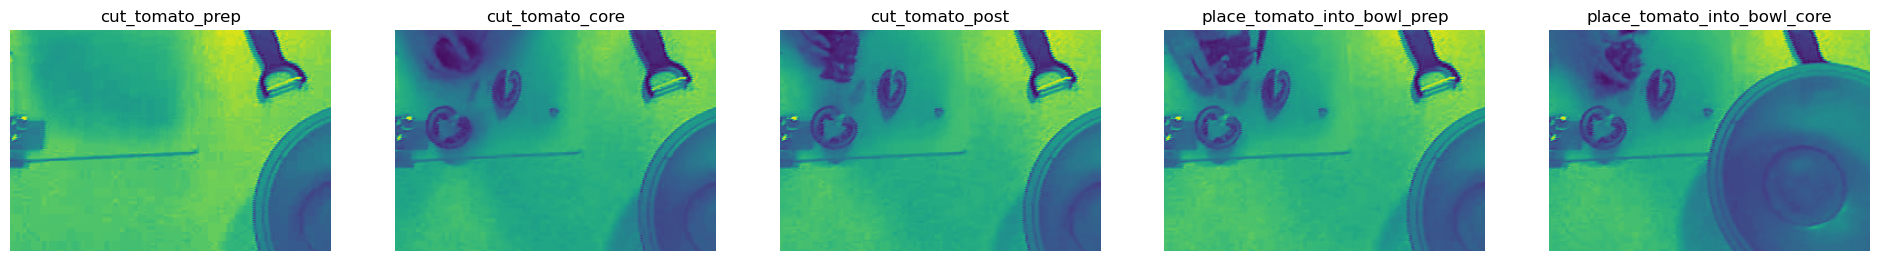

In [30]:
# Original Sample Plot Output
#### Updated from Assignment 3 root/gradcam.py ####
plt.figure(figsize=(24, 24))
for i in range(5):
    img = X[i]
    img = img / np.max(img)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(ls[y[i]])
    plt.axis('off')
plt.show()

Model Start

In [31]:
# We will have two model here
from caller import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gc_model = Model(input_size=1, output_size=2, kernel_size=(3, 3), stride=2, padding= 'same', device=device, attention='temp')

#### Updated from Assignment 3 root/gradcam.py ####
#gc_model = torchvision.models.squeezenet1_1(pretrained=True)
for param in gc_model.parameters():
    param.requires_grad = True

GradCam Process

In [33]:
#conv_module = dict([*gc_model.named_modules()])['att']
conv_module = dict([*gc_model.named_modules()])['layers'][1]
# print(GradCAM(gc_model))
print(conv_module)

ConvLSTM(
  (convLSTMcell): ConvLSTMCell()
  (temporal_attention_fc): Linear(in_features=2, out_features=1, bias=True)
)


In [39]:
# gc_model = torchvision.models.squeezenet1_1(pretrained=True)
#print(g_model)

/Users/chizhao/miniconda3/envs/cs7643-groupproject/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
#### Updated from Assignment 3 visualizers/gradcam.py ####
gradient_value = None  # Stores gradient of the module you chose above during a backwards pass.
activation_value = None  # Stores the activation of the module you chose above during a forwards pass.
def gradient_hook(a, b, gradient):
    gradient_value = gradient[0]

def activation_hook(a, b, activation):
    activation_value = activation

conv_module.register_forward_hook(activation_hook)
conv_module.register_backward_hook(gradient_hook)
# target_layer = dict([*model.named_modules()])[layer_name]
cam = None
        
#
scores_general = gc_model(X_tensor)
y_tensor = y_tensor.reshape(len(y_tensor),1)
scores = torch.gather(scores_general,1,y_tensor)
loss = torch.sum(scores)
gc_model.zero_grad()
loss.backward()  
        
gradient_data = gradient_value.numpy()
global_avg = np.mean(gradient_data,(2,3))
activate_data = activation_value.detach().numpy()

n_img,n_layer,n_w,n_h = gradient_data.shape
avg_reshape = global_avg.reshape(n_img, n_layer,1,1)
cam = []
for i in range(n_img):
    cam.append([])
    A = np.zeros(n_w * n_h).reshape(n_w,n_h)
    for j in range(n_layer):
        A_new = global_avg[i][j] * activate_data[i][j]
        A += A_new
    cam[i] = A
cam = np.array(cam)
cam[cam<0]=0
cam /= np.max(cam)
cam_scaled = []
for i in range(cam.shape[0]):
    cam_scaled.append(np.array(Image.fromarray(cam[i]).resize(X_tensor[i, 0, :, :].shape, Image.BICUBIC)))
cam = np.array(cam_scaled)
cam -= np.min(cam)
cam /= np.max(cam)


RuntimeError: The size of tensor a (144) must match the size of tensor b (290) at non-singleton dimension 3

Plt Output

In [ ]:
#### Updated from Assignment 3 root/gradcam.py ####
#gradcam_result = gc.grad_cam(X_tensor, y_tensor, gc_model)
gradcam_result = cam

plt.figure(5)
for i in range(N):
    gradcam_val = gradcam_result[i]
    img = X[i] + (matplotlib.cm.jet(gradcam_val)[:,:,:3]*255)
    img = img / np.max(img)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(ls[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()
#plt.savefig('gradcam.png', bbox_inches = 'tight')
plt.show()

In [35]:
#### Sample from CHATGPT #####
# import torch
# import torch.nn.functional as F
# import numpy as np
# import cv2
# from torchvision import models

# # Function to generate Grad-CAM heatmap
# def generate_gradcam(model, image, target_class=None):
#     model.eval()
    
#     # Hook to extract the last convolutional layer
#     def hook_fn(module, input, output):
#         global feature_map
#         feature_map = output
        
#     # Register the hook to the last convolutional layer
#     layer_name = 'layer4'  # or the last convolutional layer name in the model
#     target_layer = dict([*model.named_modules()])[layer_name]
#     target_layer.register_forward_hook(hook_fn)
    
#     # Forward pass
#     output = model(image)
    
#     # Get the gradient of the class score w.r.t feature map
#     model.zero_grad()
#     if target_class is None:
#         target_class = torch.argmax(output)  # or you can specify a class
#     target_score = output[0, target_class]
#     target_score.backward()
    
#     # Get gradients and feature maps
#     gradients = feature_map.grad
#     pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  # global average pooling
    
#     # Weighted sum of feature maps
#     for i in range(feature_map.shape[1]):
#         feature_map[0, i, :, :] *= pooled_gradients[i]
    
#     # Create heatmap by averaging the feature map across channels
#     heatmap = torch.mean(feature_map, dim=1).squeeze()
#     heatmap = F.relu(heatmap)
#     heatmap = heatmap - torch.min(heatmap)
#     heatmap = heatmap / torch.max(heatmap)
    
#     # Convert to numpy
#     heatmap = heatmap.cpu().data.numpy()
    
#     # Resize the heatmap to match input image size
#     heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[3]))
    
#     return heatmap

# # Visualization function
# def visualize_gradcam(image, heatmap, alpha=0.5):
#     # Convert image to numpy
#     image = image.squeeze().permute(1, 2, 0).cpu().numpy()
#     image = np.uint8(image * 255)  # Convert to 0-255 for visualization

#     # Convert heatmap to color (using OpenCV)
#     heatmap = np.uint8(255 * heatmap)  # 0-1 to 0-255
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
#     # Superimpose the heatmap on the image
#     superimposed_img = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    
#     return superimposed_img

# # Load a pre-trained model and image
# model = models.resnet50(pretrained=True)
# image_path = 'test.png'  # Load your image tensor here (e.g., 1x3x224x224)
# # Load your image (replace with your actual image tensor)
# image = cv2.imread(image_path)
# image = cv2.resize(image, (32, 32))  # Resize to match the input dimensions (32x32 in this example)
# image = np.transpose(image, (2, 0, 1))  # Change to CxHxW format
# image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize
# image = image.unsqueeze(0)


# # Generate Grad-CAM heatmap
# heatmap = generate_gradcam(model, image)

# # Visualize the result
# superimposed_img = visualize_gradcam(image, heatmap)
# cv2.imshow("Grad-CAM", superimposed_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
